In [1]:
import ee
import numpy as np
import folium
try:     
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()


Successfully saved authorization token.


In [2]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer    

In [15]:
import geopandas as gpd
import json

shp_file = gpd.read_file('~/Downloads/RFCx_GQ_Shapefiles/Hulu_Batang_Hari_sites_Buffer1k.shp', crs='EPSG:4326')

# define a helper function to put the geodataframe in the right format for constructing an ee object

data = json.loads(shp_file.to_json())
def shp_to_ee_fmt(geodf,index):
    data = json.loads(geodf.to_json())
    return data['features'][index]['geometry']['coordinates']
shp_file = ee.Geometry.Polygon(shp_to_ee_fmt(shp_file,10))
output = []
totals =[]
dates = [('2017-01-01','2017-12-31'), ('2018-01-01','2018-12-31'),('2019-01-01','2019-12-31'),('2020-01-01','2020-12-31'),('2021-01-01','2021-12-31')]
for date in dates:     
    start = date[0]
    end = date[1]
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(start,end).filterBounds(shp_file)
    dwImage = ee.Image(dw.max()); #mode() returns most common pixel value
    classification = dwImage.select('label').clip(shp_file)
    # classification = classification.reduce(ee.Reducer.mode())
    pixelCountStats = classification.reduceRegion(reducer=ee.Reducer.frequencyHistogram(),geometry=shp_file,scale=1,maxPixels= 1e9)
    total = classification.reduceRegion(reducer=ee.Reducer.count(),geometry=shp_file,scale=1,maxPixels= 1e9)
    pixelCounts = ee.Dictionary(pixelCountStats.get('label'))
    output.append(pixelCounts.getInfo())
    totals.append(total.getInfo()['label'])
    print(output)


EEException: Image.select: Pattern 'label' did not match any bands.

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

In [8]:
output

[{'1': 3125096.8509803903,
  '5': 400,
  '6': 14365.462745098039,
  '7': 281.9960784313725,
  '8': 23127.203921568624},
 {'1': 2984500.7098039193,
  '2': 16156.93725490196,
  '4': 2058,
  '5': 200,
  '6': 74298.57647058825,
  '7': 3800,
  '8': 82257.29019607845},
 {'1': 2664012.647058821,
  '2': 2030,
  '4': 471218.2901960794,
  '5': 565.372549019608,
  '6': 4301.101960784314,
  '8': 21144.10196078431},
 {'1': 2681296.8745098035,
  '2': 100,
  '6': 69980.08627450981,
  '7': 11325,
  '8': 235231.5294117647},
 {'1': 3013259.309803919,
  '2': 1010,
  '4': 2766.4470588235304,
  '5': 7270,
  '6': 79291.75686274511,
  '7': 1000,
  '8': 58674},
 {'1': 2465013.141176471,
  '2': 2409,
  '4': 565554.6235294112,
  '5': 301,
  '6': 96709.49803921567,
  '8': 33284.250980392164}]

<AxesSubplot:>

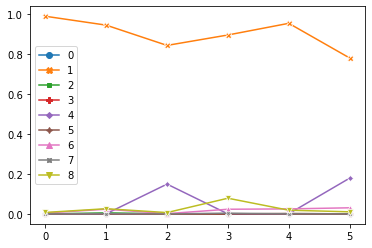

In [14]:
import seaborn as sns

sns.lineplot(data=dd,markers=True,dashes=False)

In [6]:
from collections import defaultdict

print(output)
dd = defaultdict(lambda: np.zeros(0))

for d in (output): # you can list as many input dicts as you want here
    for index in range(0,9):
        key = str(index)
        if(key not in d.keys()):
            dd[key] = np.append(dd[key],0)
        else:
            dd[key] = np.append(dd[key],d[key])
for i in range(0,9):
    dd[str(i)] = dd[str(i)] / totals

[{'1': 3125096.8509803903, '5': 400, '6': 14365.462745098039, '7': 281.9960784313725, '8': 23127.203921568624}, {'1': 2984500.7098039193, '2': 16156.93725490196, '4': 2058, '5': 200, '6': 74298.57647058825, '7': 3800, '8': 82257.29019607845}, {'1': 2664012.647058821, '2': 2030, '4': 471218.2901960794, '5': 565.372549019608, '6': 4301.101960784314, '8': 21144.10196078431}, {'1': 2681296.8745098035, '2': 100, '6': 69980.08627450981, '7': 11325, '8': 235231.5294117647}, {'1': 3013259.309803919, '2': 1010, '4': 2766.4470588235304, '5': 7270, '6': 79291.75686274511, '7': 1000, '8': 58674}, {'1': 2465013.141176471, '2': 2409, '4': 565554.6235294112, '5': 301, '6': 96709.49803921567, '8': 33284.250980392164}]


In [ ]:
from collections import defaultdict

def get_region_pixel_classes(shp_file,index):
    shp_file = ee.Geometry.Polygon(shp_to_ee_fmt(shp_file,index))
    output = []
    totals =[]
    dates = [('2017-01-01','2017-12-31'), ('2018-01-01','2018-12-31'),('2019-01-01','2019-12-31'),('2020-01-01','2020-12-31'),('2021-01-01','2021-12-31'),('2022-01-01','2022-06-30')]
    for date in dates:     
        start = date[0]
        end = date[1]
        dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(start,end).filterBounds(shp_file)
        dwImage = ee.Image(dw.mode()).clip(shp_file); #mode() returns most common pixel value
        classification = dwImage.select('label');
        # classification = classification.reduce(ee.Reducer.mode());
        pixelCountStats = classification.reduceRegion(reducer=ee.Reducer.frequencyHistogram().unweighted(),geometry=shp_file,scale=1,maxPixels= 1e9)
        total = classification.reduceRegion(reducer=ee.Reducer.count(),geometry=shp_file,scale=1,maxPixels= 1e9)
        pixelCounts = ee.Dictionary(pixelCountStats.get('label'))
        output.append(pixelCounts.getInfo())
        totals.append(total.getInfo()['label'])
    dd = defaultdict(lambda: np.zeros(0))
    for d in (output): # you can list as many input dicts as you want here
        for index in range(0,9):
            key = str(index)
            if(key not in d.keys()):
                dd[key] = np.append(dd[key],0)
            else:
                dd[key] = np.append(dd[key],d[key])
    for i in range(0,9):
        dd[str(i)] = dd[str(i)] / totals
    return dd

In [18]:
#TO DISPLAY IMAGE
startDate = '2020-01-01'
endDate = '2020-12-31'
import geopandas as gpd
import json

shp_file = gpd.read_file('~/Downloads/RFCx_GQ_Shapefiles/Hulu_Batang_Hari_sites_Buffer1k.shp', crs='EPSG:4326')

# define a helper function to put the geodataframe in the right format for constructing an ee object
def shp_to_ee_fmt(geodf,index):
    data = json.loads(geodf.to_json())
    return data['features'][index]['geometry']['coordinates']


# create the ee object
shp_file = ee.Geometry.Polygon(shp_to_ee_fmt(shp_file,10))

s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate(startDate, endDate)\
            .filterBounds(shp_file).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

s2Image = ee.Image(s2.mosaic())
s2VisParams = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
my_map = folium.Map(location=[shp_file.getInfo()['coordinates'][0][0][1],shp_file.getInfo()['coordinates'][0][0][0]], zoom_start=13, height=500)
my_map.add_ee_layer(s2Image, s2VisParams, 'sentinel-2 image')

# imageId = s2Image.get('system:index')
# dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.eq('system:index', imageId));
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(startDate,endDate).filterBounds(shp_file)
dwImage = ee.Image(dw.mode()).clip(shp_file);
classification = dwImage.select('label');
dwVisParams = {
  'min': 0,
  'max': 8,
  'palette': [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1'
  ]
};
my_map.add_ee_layer(classification, dwVisParams, 'Classified Image');

display(my_map)

In [ ]:
shp_file.getInfo()['coordinates'][0][0]

TODO: 
function that finds least cloudy image over time frame? or most recent time? 
pixel statistics for particular frame
many rois together?